In [1]:
# CONTENTS

# load test data (messages & book)
# select (random) test sequence
# encode msg and book sequence for model

# get raw book data (L2) at the start of the sequence
# init simulator with initial book
# replay sequence in simulator (actual)

# load trained model
# predict next message
# map message to one the simulator understands & is valid
# apply message to simulator (predicted)
# get L2 representation and encode it for model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"
import torch
torch.multiprocessing.set_start_method('spawn')

In [4]:
import sys
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

In [5]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint

In [6]:
data_dir = '/nfs/home/peern/LOBS5/data/raw/'
# save_dir = '/nfs/home/peern/LOBS5/data/simple_book/'
# save_dir = '/nfs/home/peern/LOBS5/data/new_enc/'
save_dir = '/nfs/home/peern/LOBS5/data/fast_encoding/'

In [7]:
message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

In [ ]:
# load test data (last day)

m = pd.read_csv(
    message_files[-1],
    names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
    index_col=False)

b = pd.read_csv(
    book_files[-1],
    index_col=False,
    header=None
)

# remove diallowed order types
m = m.loc[m.event_type.isin([1, 2, 3, 4])]
b = b.loc[m.index]

/tmp/ipykernel_3594412/3360295951.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  m = pd.read_csv(
/tmp/ipykernel_3594412/3360295951.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  m = pd.read_csv(


/tmp/ipykernel_674772/3360295951.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  m = pd.read_csv(
/tmp/ipykernel_674772/3360295951.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  m = pd.read_csv(


In [10]:
ticker = message_files[-1].rsplit('/', 1)[-1].split('_')[0]
data_date = message_files[-1].rsplit('/', 1)[-1].split('_')[1]

## Encoding

In [7]:
# Book encoding
price_levels = 500  # how many ticks to represent

In [8]:
# Message encoding
v = Vocab()
tok = Message_Tokenizer()

In [13]:
# encode from raw data

# print('<< pre processing >>')
# m_proc = tok.preproc(m, b)
# print('<< encoding >>')
# m_enc = tok.encode(m_proc, v)

# instead load from file:
msg_enc_file = sorted(glob(save_dir + '*message*.npy'))[-1]
m_enc = onp.load(msg_enc_file)

In [14]:
# remove first message from raw data as well
m = m.iloc[1:]

In [15]:
m_enc

array([[ 1003, 12010, 12008, ...,     2,     2,     2],
       [ 1003, 12009, 12007, ...,     2,     2,     2],
       [ 1003, 12010, 12008, ...,     2,     2,     2],
       ...,
       [ 1005, 12010, 12008, ...,   997,   855,   354],
       [ 1005, 12010, 12008, ...,   985,   704,   211],
       [ 1003, 12010, 12008, ...,     2,     2,     2]])

In [16]:
m.shape

(1829106, 6)

In [17]:
# m_proc.shape

In [18]:
m_enc.shape

(1829106, 22)

In [19]:
# encode from raw data:
# b_enc = preproc.process_book(b, price_levels=price_levels)

# instead load from file:
book_enc_file = sorted(glob(save_dir + '*book*.npy'))[-1]
b_enc = onp.load(book_enc_file)
# convert to sparse volume representation
b_enc = preproc.transform_L2_state(b_enc, price_levels, 100)

In [20]:
#b_enc_ = preproc.process_book(b, price_levels=price_levels)

In [21]:
b.shape

(1829107, 40)

In [22]:
b_enc.shape

(1829107, 501)

In [23]:
#b_enc_.shape

## Data Initialisation

In [9]:
n_messages = 500

In [25]:
# when to start the prediction
start_time_dt = pd.to_datetime('11:00')
# convert time into seconds after midnight
start_time = (start_time_dt - pd.to_datetime('00:00')).total_seconds()
# get seq end index
end_i = len(m.loc[m.time < start_time])

In [26]:
m_seq = m_enc[end_i - n_messages : end_i].reshape(-1)  # (n_messages [500] * levels [20], )
# book state: we already include the book state after the last message
# (different to training where we only have the book state before the first message
# and mask part of the last message)
# for message seq, we first need to append an empty message
b_seq = b_enc[end_i - n_messages + 1 : end_i + 1]      # (n_messages [500], price_levels + 1 [41])

## Simulator

In [9]:
import inference

In [10]:
os.path.abspath('')

'/nfs/home/peern/LOBS5/lob'

In [11]:
import os
import sys

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

In [12]:
from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [13]:
sim = OrderBook(price_levels=10, orderQueueLen=20)
sim

In [14]:
# init simulator at the start of the sequence
inference.reset_orderbook(sim, b.iloc[end_i - n_messages])

NameError: name 'b' is not defined

In [ ]:
# replay sequence in simulator (actual)
# so that sim is at the same state as the model
replay = inference.msgs_to_jnp(m.iloc[end_i - n_messages : end_i])
trades = sim.process_orders_array(replay)

In [ ]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [ ]:
sim.get_order_by_id_and_price(276499738, 987800)

Array([       82,    987800,         0, 276499738,     39599, 324469366],      dtype=int32)

In [ ]:
sim.get_volume_at_price(0, 988100)

Array(182, dtype=int32)

In [ ]:
# sim.orderbook_array[0][0]

In [ ]:
# side = 1  # buy order entered on bid side (executed against ask)
# order_dict = {
#     # format decimals to nanosecond precision
#     'timestamp': format(40000.1, '.9f'),
#     'type': 'limit',
#     'order_id': 100,
#     'quantity': 21,
#     'price': 988100,
#     'side': 'ask' if side == -1 else 'bid',  # TODO: should be 'buy' or 'sell'
#     'trade_id': 0  # should be trader_id in future
# }

In [ ]:
# sim.process_order(order_dict)

In [ ]:
# sim.orderbook_array[0][0]

In [ ]:
# sim.get_volume_at_price(0, 988100)

## Model

In [10]:
# necessary for checkpoints to be loaded in jupyter notebook

import nest_asyncio
nest_asyncio.apply()

In [11]:
#ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
#ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
# ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
ckpt_path = '../checkpoints/treasured-leaf-149_84yhvzjt/' # 0.5 y GOOG, (full model)

In [12]:
args = load_args_from_checkpoint(ckpt_path)

In [13]:
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=32, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=4, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [14]:
args.bsz = 10
args.num_devices = 1

In [15]:
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

In [18]:
# temporary: add args if they were hardcoded during training this model

# args.use_book_data = True
# args.n_message_layers = 2
# args.n_book_pre_layers = 1
# args.n_book_post_layers = 1

In [16]:
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=10, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/fast_encoding', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=100, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=4, n_layers=6, n_message_layers=2, num_devices=1, opt_config='standard', p_dropout=0.0, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [17]:
new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [18]:
ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

In [19]:
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [20]:
model = model_cls(training=False, step_rescale=1.0)

In [27]:
# from flax.training.train_state import TrainState
# from flax.core.frozen_dict import unfreeze


# # only use first GPU params
# params = unfreeze(jax.tree_map(lambda x: x[0], state.params))
# # state = TrainState.create(
#     apply_fn=model.apply,
#     params=unfreeze(jax.tree_map(lambda x: x[0], state.params)),
#     tx=None
# )

In [28]:
# TODO from above:
# x load trained model
#   predict next message
#   map message to one the simulator understands & is valid
#   apply message to simulator (predicted)
#   get L2 representation and encode it for model

In [29]:
# append new HID message (and next LOB state if not already in seq)
# loop: predict next token until full message is generated
# map message to one the simulator understands & is valid
# feed message to simulator (predicted) --> next book state
# encode next book state for model and append to book sequence

In [21]:
vocab_len = len(v)
batchnorm = args.batchnorm
# sample_top_n = 10
rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

### Model Validation (optional)

In [22]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/fast_encoding/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [23]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [24]:
VALID_MATRIX = valh.syntax_validation_matrix()

In [29]:
for batch_idx, batch in enumerate(tqdm(test_loader)):
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(
        batch, seq_len, n_classes, num_devices=1)
    print(
        inputs[0].shape,
        inputs[1].shape,
        labels.shape, 
        integration_timesteps[0].shape, 
        integration_timesteps[1].shape)

    print('inputs', jnp.argmax(inputs[0][0,0][-22:], axis=-1))
    print('last book state', inputs[1][0,0,-1])
    print('labels', labels)
    
    break

  0%|          | 0/365 [00:00<?, ?it/s]

(1, 10, 11000, 12011) (1, 10, 500, 501) (1, 10) (1, 10, 11000) (1, 10, 11000)
inputs [ 1005 12010 12007     0     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1]
last book state [-1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  

In [43]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

single_gpu_state = jax.tree_map(lambda x: jnp.expand_dims(x[0], axis=0), par_state)

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    
    #inputs = jax.tree_map(lambda x: jnp.squeeze(x), inputs)
    #labels = jnp.squeeze(labels)
    #integration_timesteps = jax.tree_map(lambda x: jnp.squeeze(x), integration_timesteps)

    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, single_gpu_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    #valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    #valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    #valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

  0%|          | 0/365 [00:00<?, ?it/s]

In [73]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [44]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 0.8778339
mean accuracy 0.7917808
mean rank 29.356165
median rank 0.0
mean valid mass nan
mean valid mass (top 5) nan
mean valid prediction nan
mean baseline loss (uniform over valid syntax) 5.4321027


In [75]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [88]:
field_dec

array([['generic', 'MSK'],
       ['generic', 'HID'],
       ['generic', 'NAN'],
       ...,
       ['price', '-'],
       ['direction', '0'],
       ['direction', '1']], dtype='<U10')

In [76]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [77]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.624236,0.632841,0.626838,436
event_type,0.393960,0.399946,0.396617,465
generic,1.000000,0.998603,0.999301,716
price,0.557158,0.452684,0.477146,676
size,0.213366,0.152106,0.170773,680
time,0.011118,0.037804,0.016177,685


### Forecasting

In [62]:
m_seq.reshape(-1, 22)[995]

memmap([ 1005, 12010, 12008, 11012,  1107,     3,     3,   427,   207,
            3,     5,   614,   141,   708, 12008, 11011,  1107,     3,
            5,   514,   517,   421])

In [ ]:
orig_enc = inference.construct_orig_msg_enc(
    m_seq.reshape(-1, 22)[995],
    v
)
orig_enc

Array([ 1003, 12010, 12008, 11011,  1107,     2,     2,     2,     2,
           3,     5,   514,   517,   421], dtype=int32)

In [69]:
# test
m_seq_ = jnp.array(m_seq).reshape(-1, 22).at[938].set(0).reshape(-1)

In [63]:
sim, _trades = inference.get_sim(
    book_l2_init,
    m_seq_raw,
    sim_book_levels=sim_book_levels,
    sim_queue_len=sim_queue_len,
)

In [64]:
ids = sim.get_order_ids()
ids = onp.array(ids[ids != -1])

In [65]:
ids

array([ 9445954, 32692994, 32693018, ...,        1,        1,        1],
      dtype=int32)

In [66]:
~(m_seq_raw.order_id.isin(ids)).astype(bool).values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [67]:
mask = inference.get_invalid_ref_mask(m_seq_raw, 979800, sim)
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [70]:
valh.try_find_msg(
    orig_enc,
    m_seq_,
)

comp_cols ('event_type', 'direction', 'price', 'size', 'time')
comp_i [0, 1, 2, 3, 4, 9, 10, 11, 12, 13]
searching for (new) [ 1003 12010 12008 11011  1107     3     5   514   517   421]
in seq [[ 1003 12010 12008 ...     8   723   724]
 [ 1003 12009 12007 ...     8   792   260]
 [ 1003 12010 12008 ...     9   399   786]
 ...
 [ 1003 12010 12008 ...   617   764   370]
 [ 1003 12010 12008 ...   617   924   857]
 [ 1003 12009 12007 ...   625   645    64]]
comp_cols_ref ['price', 'size', 'time', 'direction']
comp_i_ref [14, 15, 16, 17, 18, 19, 20, 21, 1]
searching for (ref) [12008 11011  1107     3     5   514   517   421 12010]
in seq [[    2     2     2 ...     2     2 12010]
 [    2     2     2 ...     2     2 12009]
 [    2     2     2 ...     2     2 12010]
 ...
 [    2     2     2 ...     2     2 12010]
 [    2     2     2 ...     2     2 12010]
 [    2     2     2 ...     2     2 12009]]
found ref matches
found match after removing 0 at idx 995


(995, 0)

In [53]:
n_gen_msgs = 100  #500
n_messages = 500
n_eval_messages = 500
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

sim_book_levels = 20 # 10
sim_queue_len = 100

In [54]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    # use dummy mask function to get entire sequence
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    use_book_data=True,
    # book_transform=True,
    use_simple_book=True,  # return (p,v) book and we'll do transorm to volume image later
    msg_seq_len=n_messages + n_eval_messages,
    return_raw_msgs=True,
    raw_data_dir='/nfs/home/peern/LOBS5/data/raw/',
    n_cache_files=100,
)
dataset_obj.setup()

In [55]:
from lob.preproc import transform_L2_state

In [102]:

ds = dataset_obj.dataset_test
for i in tqdm(range(len(ds))):
    m_seq, _, b_seq_pv, m_seq_raw, book_l2_init = ds[i]
    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))
    print('m_seq', m_seq)
    print('b_seq', b_seq)
    print('msg_seq_raw', m_seq_raw)
    print('book_l2_init', book_l2_init)
    break

  0%|          | 0/1829 [00:00<?, ?it/s]

m_seq [ 1003 12010 12008 ...     2     2     2]
b_seq [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-2.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
msg_seq_raw              time  event_type  order_id  size   price  direction
0    34200.003906           1  31920154   200  977500          1
1    34200.003906           1  31920330  2041  979000         -1
2    34200.007812           1  31921510  2041  976900          1
3    34200.007812           3  31911862    22  977200          1
4    34200.007812           1  31922478    22  977500          1
..            ...         ...       ...   ...     ...        ...
995  34202.609375           3  33163926   100  979800          1
996  34202.613281           1  33178166   100  979700          1
997  34202.613281           1  33178306   100  979700          1
998  34202.613281           1  33178322   200  979800          1
999  34202.621094          

In [56]:
ds = dataset_obj.dataset_test


# iteratre over all test data
for i in tqdm(range(len(ds))):
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[i]
    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))

    # encoded data
    m_seq_inp = m_seq[: seq_len]
    m_seq_eval = m_seq[seq_len: ]
    b_seq_inp = b_seq[: n_messages]
    b_seq_eval = b_seq[n_messages: ]
    # true L2 data
    b_seq_pv_eval = jnp.array(b_seq_pv[n_messages: ])

    # raw LOBSTER data
    m_seq_raw_inp = msg_seq_raw.iloc[: n_messages]
    m_seq_raw_eval = msg_seq_raw.iloc[n_messages: ]

    # TODO: repeat for multiple scenarios from same input to average over
    for j_rep in range(1):
        print('ITERATION', j_rep)
        print()

        # TODO: split random seed rng
        #rng, rng_ = jax.random.split(rng)
    
        # initialise simulator
        sim, _trades = inference.get_sim(
            book_l2_init,
            m_seq_raw_inp,
            sim_book_levels=sim_book_levels,
            sim_queue_len=sim_queue_len,
        )

        # generate predictions
        m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states = inference.generate(
            m_seq_inp,
            b_seq_inp,
            m_seq_raw_inp,
            n_gen_msgs,
            sim,
            state,
            model,
            batchnorm,
            rng_,
        )

        break

    break

  0%|          | 0/1829 [00:00<?, ?it/s]

ITERATION 0

delta_t_toks [ 3  3 27  6]
delta_t 24003
time 934544404
time_toks [3, 3, 937, 547, 407]
[ 1003 12010 12008 11008  1107     3     3    27     6     3     3   937
   547   407     2     2     2     2     2     2     2     2]
decoded:
[[ 1.00000000e+00  1.00000000e+00 -1.00000000e+00  1.00000000e+02
   2.40030000e+04  9.34544404e+08             nan             nan
              nan]]
NEW LIMIT ORDER
{'timestamp': '34200.934544404', 'type': 'limit', 'order_id': 88000121, 'quantity': 100, 'price': Array(978600, dtype=int32), 'side': 'bid', 'trade_id': 0}
len(m_seq_raw) 500
new raw msg time          3.420093e+04
event_type    1.000000e+00
order_id      8.800012e+07
size          1.000000e+02
price         9.786000e+05
direction     1.000000e+00
Name: 499, dtype: float64
p_change 0

delta_t_toks [  3   3   3 163]
delta_t 160
time 934544564
time_toks [3, 3, 937, 547, 567]
[ 1003 12010 12008 11009  1207     3     3     3   163     3     3   937
   547   567     2     2     2     2 

In [57]:
l2_book_states.shape

(100, 80)

In [58]:
gen_l2 = l2_book_states.reshape(l2_book_states.shape[0], -1, 2)

In [127]:
gen_l2

Array([[[979100,    100],
        [978700,    100],
        [979200,    215],
        ...,
        [    -1,      0],
        [    -1,      0],
        [    -1,      0]],

       [[979100,    100],
        [978700,    100],
        [979200,    215],
        ...,
        [    -1,      0],
        [    -1,      0],
        [    -1,      0]],

       [[979100,    100],
        [978700,    100],
        [979200,    215],
        ...,
        [    -1,      0],
        [    -1,      0],
        [    -1,      0]],

       ...,

       [[978700,    600],
        [978600,   1625],
        [978800,    100],
        ...,
        [    -1,      0],
        [979700,    222],
        [    -1,      0]],

       [[978700,    600],
        [978600,   1725],
        [978800,    100],
        ...,
        [    -1,      0],
        [979700,    222],
        [    -1,      0]],

       [[978700,    600],
        [978600,   1725],
        [978800,    100],
        ...,
        [    -1,      0],
        [979700

In [65]:
#@jax.jit
def book_loss(
        gen_l2: jax.Array,
        act_l2: jax.Array,
    ):

    def union_price_repr(a, b):
        # append prices from b not already contained in a to a
        p_not_in_a = jnp.setdiff1d(
            b[:, 0],
            a[:, 0],
            #assume_unique=True,
            size=b.shape[0],
            fill_value=-1,
        ).reshape(-1, 1)
        a = jnp.concatenate(
            [a,
             jnp.concatenate([p_not_in_a, jnp.zeros_like(p_not_in_a)], axis=1)],
            axis=0
        )
        k, v = jax.lax.sort_key_val(a[:, 0], a[:, 1])
        a = jnp.concatenate(
            (k.reshape(-1, 1), v.reshape(-1, 1)),
            axis=1
        )
        return a

    # step, (price, volume), level
    gen_l2 = gen_l2.reshape(-1, 2)
    act_l2 = act_l2.reshape(-1, 2)

    # turn ask volume negative
    gen_l2 = gen_l2.at[::2, 1].set(-gen_l2[::2, 1])
    act_l2 = act_l2.at[::2, 1].set(-act_l2[::2, 1])

    # sort by price
    gen_l2 = jnp.concatenate([gen_l2[-1: : -2], gen_l2[0: : 2]], axis=0)
    act_l2 = jnp.concatenate([act_l2[-1: : -2], act_l2[0: : 2]], axis=0)

    # print('gen')
    # print(gen_l2)
    # print('act')
    # print(act_l2)

    # all_prices = jnp.union1d(
    #     gen_l2[:, 0],
    #     act_l2[:, 0],
    #     size = gen_l2.shape[0] + act_l2.shape[0],
    #     fill_value = -1,
    # )

    # append prices not already contained in act_l2
    # p_not_in_act = jnp.setdiff1d(
    #     gen_l2[:, 0],
    #     act_l2[:, 0],
    #     assume_unique=True,
    #     size=gen_l2.shape[0],
    #     fill_value=-1,
    # ).reshape(-1, 1)
    # act_l2 = jnp.concatenate(
    #     [
    #         act_l2,
    #         jnp.concatenate([p_not_in_act, jnp.zeros_like(p_not_in_act)], axis=1)
    #     ],
    #     axis=0
    # )
    # k, v = jax.lax.sort_key_val(act_l2[:, 0], act_l2[:, 1])
    # act_l2 = jnp.concatenate(
    #     (k.reshape(-1, 1), v.reshape(-1, 1)),
    #     axis=1
    # )
    gen_l2_ = union_price_repr(gen_l2, act_l2)
    act_l2_ = union_price_repr(act_l2, gen_l2)
    
    print('gen')
    print(gen_l2_.shape)
    print(gen_l2_)
    print()
    print('act')
    print(act_l2_.shape)
    print(act_l2_)
    
    print(jnp.concatenate([gen_l2_, act_l2_], axis=1))

    return jnp.abs(act_l2_[:, 1] - gen_l2_[:, 1]).sum()

    # all_prices = jnp.unique(
    #     jnp.concatenate([gen_l2[:, 0], act_l2[:, 0]]),
    #     size = gen_l2.shape[0] + act_l2.shape[0],
    # )

In [60]:
# gen
l2_book_states[0]#[:: -2]

Array([979100,    100, 978700,    100, 979200,    215, 978600,    400,
       979300,    392, 978500,    300, 979400,    100, 978400,    188,
       979500,    310, 978100,     25, 979600,    200, 978000,    416,
       979700,    222, 977900,     18, 979800,   2041, 977800,    110,
       979900,    400, 977700,    395, 980300,    100, 977600,    125,
       980600,   1500, 977500,    888, 981000,    441, 977400,    100,
       981200,     66, 977300,    122, 982800,     10, 977200,    310,
       983000,    100, 977100,    266, 985200,    400, 977000,    172,
           -1,      0, 976900,    200,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [61]:
# act
b_seq_pv_eval[0, 1:]

Array([979100,    100, 978700,    100, 979200,    215, 978600,    300,
       979300,    392, 978500,    300, 979400,    100, 978400,    188,
       979500,    310, 978100,     25, 979600,    200, 978000,    416,
       979700,    222, 977900,     18, 979900,    400, 977800,    110,
       980000,  20825, 977700,    329, 980100,      9, 977600,    125],      dtype=int32)

In [62]:
l2_book_states[0].shape

(80,)

In [63]:
b_seq_pv_eval[0, 1:].shape

(40,)

In [66]:
# TODO:
# why are some levels missing?
# limit to fewer levels?
# evaluate over many steps
# evaluate over many samples

book_loss(l2_book_states[0], b_seq_pv_eval[0, 1:])

gen
(60, 2)
[[    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [    -1      0]
 [976900    200]
 [977000    172]
 [977100    266]
 [977200    310]
 [977300    122]
 [977400    100]
 [977500    888]
 [977600    125]
 [977700    395]
 [977800    110]
 [977900     18]
 [978000    416]
 [978100     25]
 [978400    188]
 [978500    300]
 [978600    400]
 [978700    100]
 [979100   -100]
 [979200   -215]
 [979300   -392]
 [979400   -100]
 [979500   -310]
 [979600   -200]
 [979700   -222]
 [979800  -2041]
 [979900   -400]
 [980000      0]
 [980100      0]
 [980300   -100]
 [980600  -1500]
 [981000   -441]
 [981200    -66]
 [982800    -10]
 [

Array(27716, dtype=int32)

In [58]:
# backup initial data for reset (ONCE!)
m_seq_start = m_seq.copy()
b_seq_start = b_seq.copy()

In [59]:
from gym_exchange.environment.base_env.assets.orderflow import OrderIdGenerator

In [60]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [61]:
# side, level, q, field
sim.orderbook_array[0,0,0]

Array([      100,    988100,         0, 276492538,     39599, 264867549],      dtype=int32)

In [62]:
sim.get_order_by_id_and_price(276511822, 988100)

Array([       82,    988100,         0, 276511822,     39599, 685781583],      dtype=int32)

In [63]:
sim.get_order_by_id(276511822)

Array([       82,    988100,         0, 276511822,     39599, 685781583],      dtype=int32)

In [64]:
import matplotlib.pyplot as plt

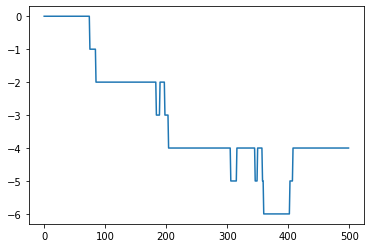

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [66]:
import inference

In [ ]:
# raw book, messages, 

In [82]:
sim, _trades = inference.get_sim(
    b.iloc[end_i - n_messages],
    m.iloc[end_i - n_messages : end_i],
    sim_book_levels=10,
    sim_queue_len=20
)

m_seq, b_seq, m_seq_raw, l2_book_states = inference.generate(
    m_seq_start.copy(),
    b_seq_start.copy(),
    m.iloc[end_i - n_messages : end_i],
    100, #500
    sim,
    state,
    model,
    batchnorm,
    rng,
)

delta_t_toks [3 3 3 3]
delta_t 0
time 5399935656857
time_toks [8, 402, 938, 659, 860]
[ 1006 12009 12007 11017  1076     3     3     3     3     8   402   938
   659   860 12007 11017  1076     8     2    21    21    34]
decoded:
[[4.00000000e+00 0.00000000e+00 1.00000000e+01 6.90000000e+01
  0.00000000e+00 5.39993566e+12 1.00000000e+01 6.90000000e+01
             nan]]
ref_part has nan [10. 69. nan]
invalid message - discarding...

delta_t_toks [  3   3  57 106]
delta_t 54103
time 5399935710960
time_toks [8, 402, 938, 713, 963]
[ 1003 12009 12007 11008  1107     3     3    57   106     8   402   938
   713   963     2     2     2     2     2     2     2     2]
decoded:
[[1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+02
  5.41030000e+04 5.39993571e+12            nan            nan
             nan]]
NEW LIMIT ORDER
{'timestamp': '39599.93571096', 'type': 'limit', 'order_id': 88000372, 'quantity': 100, 'price': Array(988000, dtype=int32), 'side': 'ask', 'trade_id': 0}
len(m_s

KeyboardInterrupt: 

In [88]:
list(range(*valh.get_idx_from_field('direction')))

[1]

In [80]:
v.ENCODING['event_type']['1']

1003

In [ ]:
# 1003 12010 12008 11013  1107     8     5    24    24    19

In [79]:
v.DECODING_GLOBAL[1003]

('event_type', '1')

In [85]:
v = Vocab()
tok = Message_Tokenizer()
tok.encode_field(5054, 'time', v)

KeyError: '4'

In [130]:
slice(*(1,2))

slice(1, 2, None)

In [ ]:
# TODO: fix gif plotting -> axis labels, title, readable font (pillow? magick?)
#       run for longer, more messages --> check variation in mid price etc.
#       get started on D(t) encoding and model (branch)

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

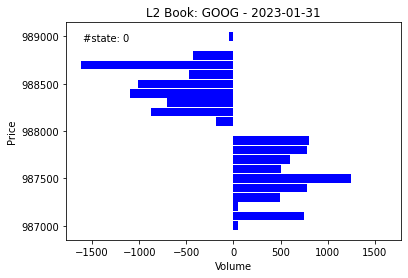

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

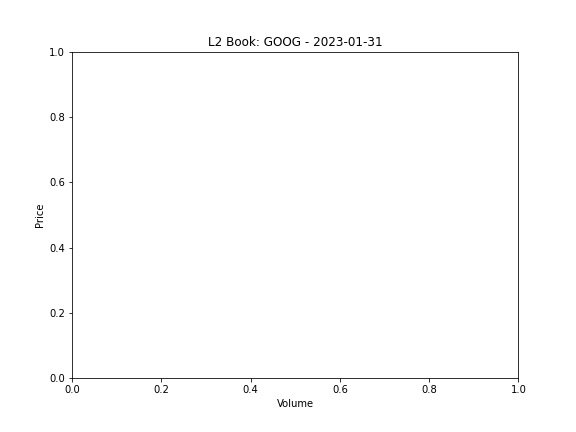

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

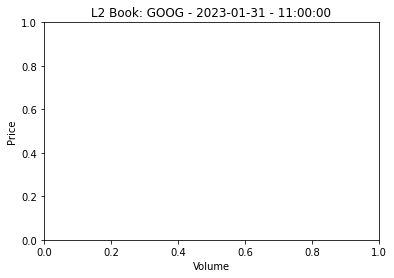

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

In [66]:
tick_size = 100
sample_top_n = 50

# reset sequences
m_seq = m_seq_start.copy()
b_seq = b_seq_start.copy()

# reset simulator
sim = OrderBook(price_levels=10, orderQueueLen=20)
# init simulator at the start of the sequence
reset_orderbook(sim, b.iloc[end_i - n_messages])
# replay sequence in simulator (actual)
# so that sim is at the same state as the model
replay = msgs_to_jnp(m.iloc[end_i - n_messages : end_i])
trades = sim.process_orders_array(replay)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

id_gen = OrderIdGenerator()
valid_mask_array = valh.syntax_validation_matrix(v)
l = Message_Tokenizer.MSG_LEN

#for _ in range(100): #100
msg_todo = 100
while msg_todo > 0:
    rng, rng_ = jax.random.split(rng)

    #losses = []
    #accs = []
    m_seq = valh.append_hid_msg(m_seq)

    idx = range(l)
    # reversed_idx = [i \
    #    for field_i in reversed(list(range(len(Message_Tokenizer.FIELDS)))) \
    #    for i in range(*LOBSTER_Dataset._get_tok_slice_i(field_i))]

    for mask_i in idx:# reversed_idx:
        # syntactically valid tokens for current message position
        valid_mask = valid_mask_array[mask_i]

        m_seq, _ = valh.mask_last_msg_in_seq(m_seq, mask_i)
        #print(m_seq[-20:])
        # inference
        input = (
            one_hot(
                jnp.expand_dims(m_seq, axis=0), vocab_len
            ).astype(float),
            jnp.expand_dims(b_seq, axis=0)
        )
        integration_timesteps = (
            jnp.ones((1, len(m_seq))), 
            jnp.ones((1, len(b_seq)))
        )
        logits = valh.predict(
            input,
            integration_timesteps, state, model, batchnorm)
            #integration_timesteps, params, model, batchnorm)
        
        #print('1007', logits[0,1007], '1008', logits[0,1008], '1107', logits[0,1107])
        
        # filter out (syntactically) invalid tokens for current position
        #if valid_mask is not None:
        #    logits = valh.filter_valid_pred(logits, valid_mask)
        
        # TODO: remove - just for debugging
        #label = m_enc[end_i][mask_i]
        #losses.append(cross_entropy_loss(logits, label))
        #accs.append(compute_accuracy(logits, label))

        #print(m_seq[-20:])
        # update sequence
        # note: rng arg expects one element per batch element
        rng, rng_ = jax.random.split(rng)
        m_seq = valh.fill_predicted_toks(m_seq, logits, sample_top_n, jnp.array([rng_]))

    ### NEW:

    #m_seq_raw = m.iloc[end_i - n_messages : end_i]
    m_seq_raw = m.iloc[end_i - n_messages + 1 : end_i]
    order_id = id_gen.step()

    # parse generated message for simulator, also getting corrected raw message
    # (needs to be encoded and overwrite originally generated message)
    sim_msg, msg_corr = get_sim_msg(
        m_seq[-l:],
        m_seq[:-l],  # TODO: check if this should be the sequence without the generated msg
        m_seq_raw,
        sim,
        tok,
        v,
        new_order_id=order_id,
        tick_size=tick_size
    )

    if sim_msg is None:
        print('invalid message - discarding...')
        # cut away generated message and pad begginning of sequence
        m_seq = onp.concatenate([
            onp.full((l,), Vocab.NA_TOK),
            m_seq[: -l]])
        continue

    display(sim_msg)
    #print('quantitity', sim_msg['quantity'], 'price', sim_msg['price'])

    # replace in sequence
    #print('before', m_seq[-l:])
    #print('after', msg_corr)
    m_seq = m_seq.at[-l:].set(msg_corr)

    # feed message to simulator, updating book state
    p_mid_old = onp.round((sim.get_best_ask() + sim.get_best_bid()) / 2, -2).astype(int)
    #p_bid_old = sim.get_best_bid()
    _trades = sim.process_order(sim_msg)
    #p_bid_new = sim.get_best_bid()
    p_mid_new = onp.round((sim.get_best_ask() + sim.get_best_bid()) / 2, -2).astype(int)
    # p_change = (p_bid_new - p_bid_old) // tick_size
    p_change = (p_mid_new - p_mid_old) // tick_size

    # get new book state
    book = sim.get_L2_state()
    
    # new_book = encode_L2_state(book, price_levels=(b_seq.shape[1] - 1))
    # # prepend price jump to book state
    # new_book = jnp.concatenate([jnp.array([p_change]), new_book])
    # #print('new_book', new_book.shape, new_book)
    
    new_book_raw = jnp.concatenate([jnp.array([p_change]), book]).reshape(1,-1)
    new_book = preproc.transform_L2_state(new_book_raw, 500, 100)#[0]
    #print('new_book', new_book.shape, new_book)
    
    # update book sequence
    #b_seq = jnp.concatenate([b_seq[1:], jnp.expand_dims(new_book, axis=0)])
    b_seq = jnp.concatenate([b_seq[1:], new_book])

    print('p_change', p_change)
    print()

    msg_todo -= 1


NEW LIMIT ORDER


{'timestamp': '39599.935684982',
 'type': 'limit',
 'order_id': 88000221,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.935669965',
 'type': 'limit',
 'order_id': 88000222,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER EXECUTION
event_type: 4
remaining quantity 200
(event_type=4) -5 from 200 @987900.0 --> 195
orig_i [[414]]
m_seq[orig_i] [[[    8   402   327   446   553  1003  1057 12007 11010 12009     8
     402   355   501   703  1005  1057 12007 11008 12009]]]


{'timestamp': '39599.935657698',
 'type': 'limit',
 'order_id': 88000223,
 'quantity': 5,
 'price': Array(987900., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER EXECUTION
event_type: 4
EXECUTION AT WRONG PRICE
invalid message - discarding...
ORDER EXECUTION
event_type: 4
EXECUTION AT WRONG PRICE
invalid message - discarding...
ORDER EXECUTION
event_type: 4
remaining quantity 195
(event_type=4) -12 from 195 @987900.0 --> 183
orig_i [[414]]
m_seq[orig_i] [[[    8   402   355   502   192  1003  1107 12008 11008 12010     2
       2     2     2     2     2     2     2     2     2]]]


{'timestamp': '39599.927657704',
 'type': 'limit',
 'order_id': 88000226,
 'quantity': 12,
 'price': Array(987900., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927684659',
 'type': 'limit',
 'order_id': 88000227,
 'quantity': 200,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 100
total liquidity at price 1056
event_type: 3
matches: []
no perfect match found
looking for order 276489698 at price 988200.0
remaining quantity 100
(event_type=3) -100 from 100 @988200.0 --> 0


{'timestamp': '39599.927683698',
 'type': 'delete',
 'order_id': 276489698,
 'quantity': Array(100, dtype=int32),
 'price': Array(988200., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.92667866',
 'type': 'limit',
 'order_id': 88000229,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 3
side 0
removed_quantity (raw) 100
total liquidity at price 706
event_type: 3
matches: []
no perfect match found
looking for order 276489650 at price 988300.0
remaining quantity 81
(event_type=3) -81 from 81 @988300.0 --> 0


{'timestamp': '39599.927725790',
 'type': 'delete',
 'order_id': 276489650,
 'quantity': Array(81, dtype=int32),
 'price': Array(988300., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927755661',
 'type': 'limit',
 'order_id': 88000231,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 100
total liquidity at price 600
event_type: 3
matches: []
no perfect match found
looking for order 90000000 at price 987700.0
remaining quantity 350
(event_type=2) -100 from 350 @987700.0 --> 250


{'timestamp': '39599.927771864',
 'type': 'cancel',
 'order_id': 90000000,
 'quantity': 100,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927765665',
 'type': 'limit',
 'order_id': 88000233,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 490
event_type: 3
matches: []
no perfect match found
looking for order 276488422 at price 987300.0
remaining quantity 50
(event_type=3) -50 from 50 @987300.0 --> 0


{'timestamp': '39599.927733662',
 'type': 'delete',
 'order_id': 276488422,
 'quantity': Array(50, dtype=int32),
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 440
event_type: 3
matches: []
no perfect match found
looking for order 276500422 at price 987300.0
remaining quantity 22
(event_type=3) -22 from 22 @987300.0 --> 0


{'timestamp': '39599.927733684',
 'type': 'delete',
 'order_id': 276500422,
 'quantity': Array(22, dtype=int32),
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 22
total liquidity at price 418
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 306
(event_type=2) -22 from 306 @987300.0 --> 284


{'timestamp': '39599.927739582',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 22,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927758671',
 'type': 'limit',
 'order_id': 88000237,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 10
total liquidity at price 182
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39596.927721651',
 'type': 'limit',
 'order_id': 88000239,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790760824',
 'type': 'limit',
 'order_id': 88000240,
 'quantity': 400,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 0
side 0
removed_quantity (raw) 100
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.790735657996',
 'type': 'limit',
 'order_id': 88000242,
 'quantity': 62,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 2
side 0
removed_quantity (raw) 3
total liquidity at price 975
event_type: 3
matches: []
no perfect match found
looking for order 276489698 at price 988200.0
remaining quantity 100
(event_type=2) -3 from 100 @988200.0 --> 97


{'timestamp': '39599.790733659',
 'type': 'cancel',
 'order_id': 276489698,
 'quantity': 3,
 'price': Array(988200., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '38599.790692651004',
 'type': 'limit',
 'order_id': 88000244,
 'quantity': 50,
 'price': Array(987300, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790702657',
 'type': 'limit',
 'order_id': 88000245,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.792757656',
 'type': 'limit',
 'order_id': 88000246,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790696661',
 'type': 'limit',
 'order_id': 88000247,
 'quantity': 200,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.790717659',
 'type': 'limit',
 'order_id': 88000248,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -4
side 1
removed_quantity (raw) 100
total liquidity at price 500
event_type: 3
matches: []
no perfect match found
looking for order 90000000 at price 987600.0
remaining quantity 250
(event_type=2) -100 from 250 @987600.0 --> 150


{'timestamp': '39599.790717712',
 'type': 'cancel',
 'order_id': 90000000,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39601.792670824',
 'type': 'limit',
 'order_id': 88000250,
 'quantity': 200,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -2
side 1
removed_quantity (raw) 100
total liquidity at price 1082
event_type: 3
matches: []
no perfect match found
looking for order 276499746 at price 987800.0
remaining quantity 100
(event_type=3) -100 from 100 @987800.0 --> 0


{'timestamp': '39599.798705692',
 'type': 'delete',
 'order_id': 276499746,
 'quantity': Array(100, dtype=int32),
 'price': Array(987800., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.792760702',
 'type': 'limit',
 'order_id': 88000252,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -4
side 1
removed_quantity (raw) 100
total liquidity at price 500
event_type: 3
matches: []
no perfect match found
looking for order 276503738 at price 987600.0
remaining quantity 200
(event_type=2) -100 from 200 @987600.0 --> 100


{'timestamp': '39599.792736760',
 'type': 'cancel',
 'order_id': 276503738,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927669725',
 'type': 'limit',
 'order_id': 88000254,
 'quantity': 50,
 'price': Array(988100, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.927672655',
 'type': 'limit',
 'order_id': 88000255,
 'quantity': 100,
 'price': Array(987200, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805690654',
 'type': 'limit',
 'order_id': 88000256,
 'quantity': 50,
 'price': Array(987100, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805698662',
 'type': 'limit',
 'order_id': 88000257,
 'quantity': 600,
 'price': Array(987000, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -9
side 1
removed_quantity (raw) 50
total liquidity at price 800
event_type: 3
matches: []
no perfect match found
looking for order 276515962 at price 987100.0
remaining quantity 600
(event_type=2) -50 from 600 @987100.0 --> 550


{'timestamp': '39599.808696656',
 'type': 'cancel',
 'order_id': 276515962,
 'quantity': 50,
 'price': Array(987100., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 600
total liquidity at price 423
event_type: 3
matches: []
no perfect match found
looking for order 276503582 at price 987900.0
remaining quantity 65
(event_type=3) -65 from 65 @987900.0 --> 0


{'timestamp': '39599.805700668',
 'type': 'delete',
 'order_id': 276503582,
 'quantity': Array(65, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 358
event_type: 3
matches: []
no perfect match found
looking for order 276515718 at price 987900.0
remaining quantity 100
(event_type=3) -100 from 100 @987900.0 --> 0


{'timestamp': '39599.805659719',
 'type': 'delete',
 'order_id': 276515718,
 'quantity': Array(100, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.805668665',
 'type': 'limit',
 'order_id': 88000261,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 52
total liquidity at price 258
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.805669766',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 238
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.805690781',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.808660797',
 'type': 'limit',
 'order_id': 88000264,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 218
event_type: 3
matches: []
no perfect match found
looking for order 276515718 at price 987900.0
remaining quantity 100
(event_type=3) -100 from 100 @987900.0 --> 0


{'timestamp': '39599.806660765',
 'type': 'delete',
 'order_id': 276515718,
 'quantity': Array(100, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 22
total liquidity at price 1300
event_type: 3
matches: []
no perfect match found
looking for order 276492482 at price 987700.0
remaining quantity 50
(event_type=2) -22 from 50 @987700.0 --> 28


{'timestamp': '39599.806660808',
 'type': 'cancel',
 'order_id': 276492482,
 'quantity': 22,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.804712824',
 'type': 'limit',
 'order_id': 88000267,
 'quantity': 500,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 200
total liquidity at price 1778
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=3) -200 from 200 @987700.0 --> 0


{'timestamp': '39599.805739753',
 'type': 'delete',
 'order_id': 276513250,
 'quantity': Array(200, dtype=int32),
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '34599.805690818',
 'type': 'limit',
 'order_id': 88000269,
 'quantity': 600,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80171283',
 'type': 'limit',
 'order_id': 88000270,
 'quantity': 200,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80170083',
 'type': 'limit',
 'order_id': 88000271,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 100
total liquidity at price 232
event_type: 3
matches: []
no perfect match found
looking for order 276492538 at price 988100.0
remaining quantity 100
(event_type=3) -100 from 100 @988100.0 --> 0


{'timestamp': '39599.801707996',
 'type': 'delete',
 'order_id': 276492538,
 'quantity': Array(100, dtype=int32),
 'price': Array(988100., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -10
side 1
removed_quantity (raw) 50
total liquidity at price 650
event_type: 3
matches: []
no perfect match found
looking for order 276497914 at price 987000.0
remaining quantity 50
(event_type=3) -50 from 50 @987000.0 --> 0


{'timestamp': '39599.801708299',
 'type': 'delete',
 'order_id': 276497914,
 'quantity': Array(50, dtype=int32),
 'price': Array(987000., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 2
total liquidity at price 2178
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=2) -2 from 200 @987700.0 --> 198


{'timestamp': '39599.808708215',
 'type': 'cancel',
 'order_id': 276513250,
 'quantity': 2,
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786708811',
 'type': 'limit',
 'order_id': 88000275,
 'quantity': 100,
 'price': Array(988100, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800698817',
 'type': 'limit',
 'order_id': 88000276,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 311
total liquidity at price 158
event_type: 3
matches: []
no perfect match found
looking for order 276509918 at price 987900.0
remaining quantity 20
(event_type=3) -20 from 20 @987900.0 --> 0


{'timestamp': '39599.800698996',
 'type': 'delete',
 'order_id': 276509918,
 'quantity': Array(20, dtype=int32),
 'price': Array(987900., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.801698859',
 'type': 'limit',
 'order_id': 88000278,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80070382',
 'type': 'limit',
 'order_id': 88000279,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800703859',
 'type': 'limit',
 'order_id': 88000280,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.800698815',
 'type': 'limit',
 'order_id': 88000281,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price 0
side 0
removed_quantity (raw) 50
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 200
total liquidity at price 150
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
ORDER CANCEL / DELETE
rel price 0
side 1
removed_quantity (raw) 2
total liquidity at price 0
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.800704793',
 'type': 'limit',
 'order_id': 88000286,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 446
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 284
(event_type=2) -100 from 284 @987300.0 --> 184


{'timestamp': '39599.800982826',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 100,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -7
side 1
removed_quantity (raw) 100
total liquidity at price 346
event_type: 3
matches: []
no perfect match found
looking for order 276503714 at price 987300.0
remaining quantity 184
(event_type=2) -100 from 184 @987300.0 --> 84


{'timestamp': '39599.800763848',
 'type': 'cancel',
 'order_id': 276503714,
 'quantity': 100,
 'price': Array(987300., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1450
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.800700815',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 100
total liquidity at price 150
event_type: 3
matches: []
no perfect match found
looking for order 276489674 at price 987200.0
remaining quantity 50
(event_type=3) -50 from 50 @987200.0 --> 0


{'timestamp': '39599.800708848',
 'type': 'delete',
 'order_id': 276489674,
 'quantity': Array(50, dtype=int32),
 'price': Array(987200., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.798717743004',
 'type': 'limit',
 'order_id': 88000291,
 'quantity': 100,
 'price': Array(987100, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786719859',
 'type': 'limit',
 'order_id': 88000292,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786719859',
 'type': 'limit',
 'order_id': 88000293,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 6
side 0
removed_quantity (raw) 100
total liquidity at price 468
event_type: 3
matches: []
no perfect match found
looking for order 276489778 at price 988600.0
remaining quantity 50
(event_type=3) -50 from 50 @988600.0 --> 0


{'timestamp': '39599.786666766',
 'type': 'delete',
 'order_id': 276489778,
 'quantity': Array(50, dtype=int32),
 'price': Array(988600., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786689825996',
 'type': 'limit',
 'order_id': 88000295,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1350
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.786657765',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786717725',
 'type': 'limit',
 'order_id': 88000297,
 'quantity': 100,
 'price': Array(987500, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786655815',
 'type': 'limit',
 'order_id': 88000298,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786721876',
 'type': 'limit',
 'order_id': 88000299,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 100
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.786722859004',
 'type': 'limit',
 'order_id': 88000301,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.786760859',
 'type': 'limit',
 'order_id': 88000302,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 8
side 0
removed_quantity (raw) 100
total liquidity at price 431
event_type: 3
matches: []
no perfect match found
looking for order 276487218 at price 988800.0
remaining quantity 100
(event_type=3) -100 from 100 @988800.0 --> 0


{'timestamp': '39599.786757895',
 'type': 'delete',
 'order_id': 276487218,
 'quantity': Array(100, dtype=int32),
 'price': Array(988800., dtype=float32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 100
total liquidity at price 232
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.805758895',
 'type': 'limit',
 'order_id': 88000305,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80575886',
 'type': 'limit',
 'order_id': 88000306,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.806758859',
 'type': 'limit',
 'order_id': 88000307,
 'quantity': 3,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.696722859',
 'type': 'limit',
 'order_id': 88000308,
 'quantity': 100,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -5
side 1
removed_quantity (raw) 100
total liquidity at price 1350
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.696761845',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 50
total liquidity at price 100
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.806758831',
 'type': 'limit',
 'order_id': 88000311,
 'quantity': 304,
 'price': Array(987000, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.806758858',
 'type': 'limit',
 'order_id': 88000312,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 200
total liquidity at price 38
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.809769859',
 'type': 'limit',
 'order_id': 88000314,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.80976886',
 'type': 'limit',
 'order_id': 88000315,
 'quantity': 100,
 'price': Array(987900, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change -2

NEW LIMIT ORDER


{'timestamp': '39599.809758858',
 'type': 'limit',
 'order_id': 88000316,
 'quantity': 100,
 'price': Array(987800, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39600.813763859',
 'type': 'limit',
 'order_id': 88000317,
 'quantity': 50,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price 1
side 0
removed_quantity (raw) 2
total liquidity at price 62
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.813763859',
 'type': 'limit',
 'order_id': 88000319,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -3
side 1
removed_quantity (raw) 100
total liquidity at price 1250
event_type: 3
matches: []
no perfect match found
looking for order 276507230 at price 987500.0
remaining quantity 100
(event_type=3) -100 from 100 @987500.0 --> 0


{'timestamp': '39599.813769860',
 'type': 'delete',
 'order_id': 276507230,
 'quantity': Array(100, dtype=int32),
 'price': Array(987500., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815763997',
 'type': 'limit',
 'order_id': 88000321,
 'quantity': 50,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815758766',
 'type': 'limit',
 'order_id': 88000322,
 'quantity': 100,
 'price': Array(987400, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815758859',
 'type': 'limit',
 'order_id': 88000323,
 'quantity': 100,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -1
side 1
removed_quantity (raw) 400
total liquidity at price 2876
event_type: 3
matches: []
no perfect match found
looking for order 276513250 at price 987700.0
remaining quantity 200
(event_type=3) -200 from 200 @987700.0 --> 0


{'timestamp': '39599.815759996',
 'type': 'delete',
 'order_id': 276513250,
 'quantity': Array(200, dtype=int32),
 'price': Array(987700., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815763859',
 'type': 'limit',
 'order_id': 88000325,
 'quantity': 200,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.815768858',
 'type': 'limit',
 'order_id': 88000326,
 'quantity': 200,
 'price': Array(987600, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.81575886',
 'type': 'limit',
 'order_id': 88000327,
 'quantity': 66,
 'price': Array(986800, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -2
side 1
removed_quantity (raw) 100
total liquidity at price 1300
event_type: 3
matches: []
no perfect match found
looking for order 276503738 at price 987600.0
remaining quantity 200
(event_type=2) -100 from 200 @987600.0 --> 100


{'timestamp': '39599.815797913',
 'type': 'cancel',
 'order_id': 276503738,
 'quantity': 100,
 'price': Array(987600., dtype=float32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

ORDER CANCEL / DELETE
rel price -8
side 1
removed_quantity (raw) 300
total liquidity at price 904
event_type: 3
matches: []
no perfect match found
invalid message - discarding...
NEW LIMIT ORDER


{'timestamp': '39599.815758845',
 'type': 'limit',
 'order_id': 88000330,
 'quantity': 300,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871758996',
 'type': 'limit',
 'order_id': 88000331,
 'quantity': 304,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871758862',
 'type': 'limit',
 'order_id': 88000332,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.871760861',
 'type': 'limit',
 'order_id': 88000333,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0

NEW LIMIT ORDER


{'timestamp': '39599.870758861',
 'type': 'limit',
 'order_id': 88000334,
 'quantity': 100,
 'price': Array(987700, dtype=int32),
 'side': 'bid',
 'trade_id': 0}

p_change 0



,time,event_type,order_id,size,price,direction
0,39599.935653861,3,276500518,100,988200.0,ask
1,39599.935683991,3,276495642,100,988200.0,ask
2,39599.935735089,3,276495642,100,988200.0,ask
3,39599.935743174,3,276486186,100,988500.0,ask
4,39599.937776683,3,276491902,100,988200.0,ask
...,...,...,...,...,...,...
495,39599.346980275,2,276498870,51,988400.0,ask
496,39599.298788258,1,88001979,100,987700,bid
497,39599.297802714,3,88001833,50,987100.0,bid
498,39598.294794258,1,88001981,306,987000,bid


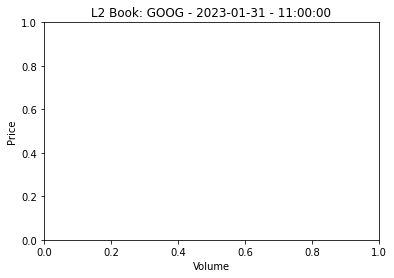

In [144]:
b_seq

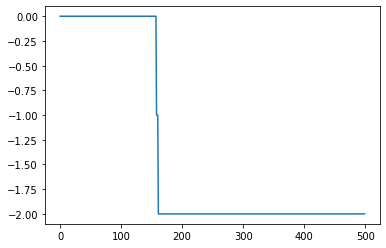

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

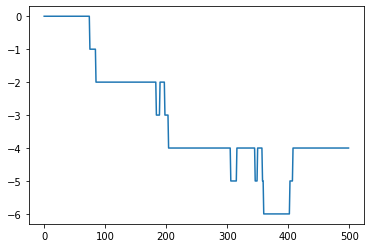

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

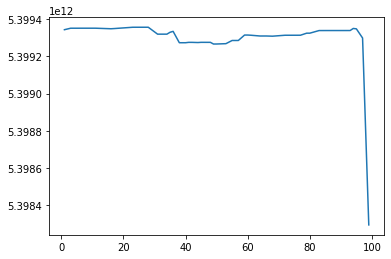

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

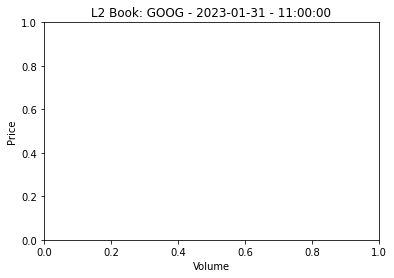

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

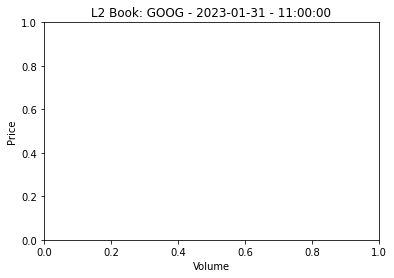

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

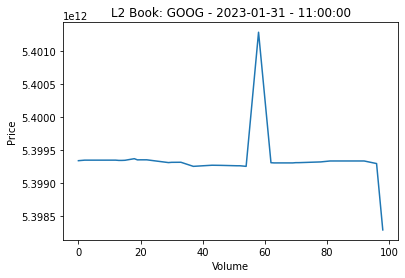

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

## Scratch Work

In [70]:
# decode predicted message
pred_msg = tok.decode(m_seq[-20:], v).flatten()
pred_msg

array([5.00500501e+12, 1.00000000e+00, 1.00000000e+01, 1.00000000e+00,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan])

In [69]:
v.DECODING_GLOBAL[980]

('time', '977')

In [71]:
valh.validate_msg(m_seq[-20:], tok, v)

True

In [74]:
sim.orderbook_array.shape

(2, 10, 20, 6)

In [76]:
# side: 0: asks 1: bids
sim.get_volume_at_price(0, 988000)

Array(0, dtype=int32)

In [77]:
# side: 0: asks 1: bids
sim.get_volume_at_price(1, 987000)

Array(50, dtype=int32)

In [78]:
sim.get_volume_at_price(0, 988500)

Array(1012, dtype=int32)

In [79]:
from gym_exchange import Config
from gymnax_exchange.jaxob.JaxOrderbook import INITID

In [80]:
sim.get_init_volume_at_price(0, 988500)

Array(174, dtype=int32)

In [81]:
sim.get_L2_state()

Array([988100,    182, 987900,    802, 988200,   1056, 987800,    782,
       988300,    706, 987700,    600, 988400,   1100, 987600,    500,
       988500,   1012, 987500,   1250, 988600,    468, 987400,    775,
       988700,   1615, 987300,    490, 988800,    431, 987200,     50,
       989000,     50, 987100,    750,     -1,      0, 987000,     50],      dtype=int32)

In [ ]:
# TODO: add functions to jorderbook.py

In [ ]:
def msg_to_raw(msg, bid_price, tick_size):
    """Convert message to raw data format."""
    assert len(msg) == 5
    # time
    msg[0] = msg[0] * 1e-9 + 9.5 * 3600
    # price
    msg[3] = bid_price + int(msg[3]) * tick_size
    # direction
    msg[4] = msg[4] * 2 - 1
    return msg

In [ ]:
# actual next message (not predicted and not part of seq)
m_enc[end_i]

array([    8,   402,   328,   183,   770,  1003,  1207, 11107, 11011,
       11109,     8,   403,     9,   666,   752,  1005,  1107, 11107,
       11010, 11109])

In [ ]:
#raw_seq = m.iloc[end_i - n_messages: end_i].copy()
#raw_seq.drop('order_id', inplace=True, axis=1)

In [301]:
test_msg = m_enc[end_i].copy()
print('correct', test_msg)
#test_msg[2] -= 1  # modify time
#test_msg[6] += 1  # modify size
#test_msg[8] += 1  # modify price
print('modified', test_msg)

correct [    8   402   328   183   770  1003  1207 11107 11011 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]
modified [    8   402   328   183   770  1003  1207 11107 11012 11109     8   403
     9   666   752  1005  1107 11107 11010 11109]


In [85]:
# use generated message
test_msg = m_seq[-20:].copy()

In [102]:
m_seq_raw = m.iloc[end_i - n_messages : end_i]

id_gen = OrderIdGenerator()
order_id = id_gen.step()

sim_msg, raw_vals = get_sim_msg(
    test_msg,
    m_seq,
    m_seq_raw,
    sim,
    tok,
    v,
    new_order_id=order_id,
    tick_size=100
)
sim_msg

raw_vals
['005005005005005', '1', '0010', '+01', '0']


{'timestamp': '39205.005005005',
 'type': 1,
 'order_id': 88000004,
 'quantity': 10,
 'price': Array(988000, dtype=int32),
 'side': 'ask',
 'trade_id': 0}

In [103]:
# TODO: do this for type 1, 4 messages as well

tok = Message_Tokenizer()
tok.encode_msg(raw_vals, v)

time 005005005005005
delim_i [3, 6, 9, 12]
1003
[8, 8, 8, 8, 8]

event_type 1
[1003]

size 0010
delim_i []
10003
[1017]

price +01
delim_i [1]
105
[11107, 11008]

direction 0
[11109]



array([    8,     8,     8,     8,     8,  1003,  1017, 11107, 11008,
       11109])

In [ ]:
sim.process_order(sim_msg)

[       5       -1       10   988200        0 32429970    39600  6663749]
[[[[      100    988000         0 276499246     39599 322500767]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[      100    988100         0 276492538     39599 264867549]
   [       82    988100         0 276511822     39599 685781583]
   [       -1        -1        -1        -1        -1        -1]
   ...
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]
   [       -1        -1        -1        -1        -1        -1]]

  [[       81    988200         0 276491886     39599  26281485]
   [      100    988200         0 276500518     39599  33606933

(Array([[-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1]], dtype=int32),
 Array([       5,       -1,       10,   988200,        0, 32429970,
           39600,  6663749], dtype=int32))

In [ ]:
input[0].shape

(1, 10000, 11111)

In [ ]:
input[1].shape

(1, 500, 41)

In [ ]:
# TODO: refactor slightly and work in simulation step
#       and simulator matching orders

pred_n_messages = 1
valid_mask_array = valh.syntax_validation_matrix()
inf_seq = valh.pred_msg(
    start_seq,
    pred_n_messages,
    state,
    model,
    args.batchnorm,
    rng,
    valid_mask_array
)